In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from scipy import stats
from sqlalchemy import create_engine
%matplotlib inline

In [166]:
server = 'omnihub.database.windows.net'  # e.g., 'localhost\SQLEXPRESS'
database = 'omnihub'
username = 'omnihubadmin'
password = 'Administrator@123'
password = urllib.parse.quote(password)
cnxn = create_engine('mssql+pyodbc://' + username + ':' + password + '@' + server + '/' + database + '?driver=ODBC+Driver+18+for+SQL+Server')

In [175]:
qry = 'SELECT Wait.ProvinceTerritoryID, [Wait].[Year], Wait.IndicatorID, Pop.SpecialtyID, FLOOR(AVG(Wait.NinetiethPercentileDay)) NinetiethPercentileDay, FLOOR(AVG(Pop.PopulationRatio)) PopulationRatio, FLOOR(AVG(Pop.NoOfPhysicians)) NoOfPhysicians, FLOOR(AVG(Bed.NoOfBeds)) NoOfBeds FROM omnihub.Fact_WaitingTimeMod Wait JOIN omnihub.Fact_PopulationDistribution Pop ON Pop.ProvinceTerritoryID = Wait.ProvinceTerritoryID AND Pop.[Year] = Wait.[Year] JOIN omnihub.Fact_BedsStaffed Bed ON Bed.ProvinceTerritoryID = Wait.ProvinceTerritoryID WHERE Wait.Year IN (2021, 2022) GROUP BY Wait.ProvinceTerritoryID, [Wait].[Year], Wait.IndicatorID, Pop.SpecialtyID ORDER BY Wait.[Year]'
waiting_time_df = pd.read_sql(qry, cnxn)

In [176]:
waiting_time_df.head()

,ProvinceTerritoryID,Year,IndicatorID,SpecialtyID,NinetiethPercentileDay,PopulationRatio,NoOfPhysicians,NoOfBeds
0,AB,2021,IND001,SP0011,64.0,0.0,4.0,15
1,AB,2021,IND001,SP0003,64.0,94.0,1129.0,15
2,AB,2021,IND001,SP0010,64.0,0.0,6.0,15
3,AB,2021,IND001,SP0002,64.0,207.0,2211.0,15
4,AB,2021,IND001,SP0012,64.0,68.0,850.0,15


In [177]:
def get_anova_results(dataframe, numeric_column_name, category_column_name):
    # Perform ANOVA
    anova_result = stats.f_oneway(*[group[numeric_column_name].values for name, group in dataframe.groupby(category_column_name)])
    statistically_significant = anova_result.pvalue < 0.05
    print(f"{category_column_name} - {numeric_column_name}:\nF-Statistic: {anova_result.statistic}, P-Value: {anova_result.pvalue}")
    print(f"Statistically significant: {statistically_significant}\n")

In [178]:
print("ANOVA Results:")
get_anova_results(waiting_time_df, "NinetiethPercentileDay", "Year")
get_anova_results(waiting_time_df, "NinetiethPercentileDay", "IndicatorID")
get_anova_results(waiting_time_df, "NinetiethPercentileDay", "ProvinceTerritoryID")
get_anova_results(waiting_time_df, "NinetiethPercentileDay", "SpecialtyID")

ANOVA Results:
Year - NinetiethPercentileDay:
F-Statistic: 49.24984474974257, P-Value: 2.3467667176770292e-12
Statistically significant: True

IndicatorID - NinetiethPercentileDay:
F-Statistic: 7126.171850780542, P-Value: 0.0
Statistically significant: True

ProvinceTerritoryID - NinetiethPercentileDay:
F-Statistic: 36.713986884313904, P-Value: 3.347379965307636e-58
Statistically significant: True

SpecialtyID - NinetiethPercentileDay:
F-Statistic: 0.09799169145630007, P-Value: 0.9999999999999999
Statistically significant: False



C:\Users\risha\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\risha\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


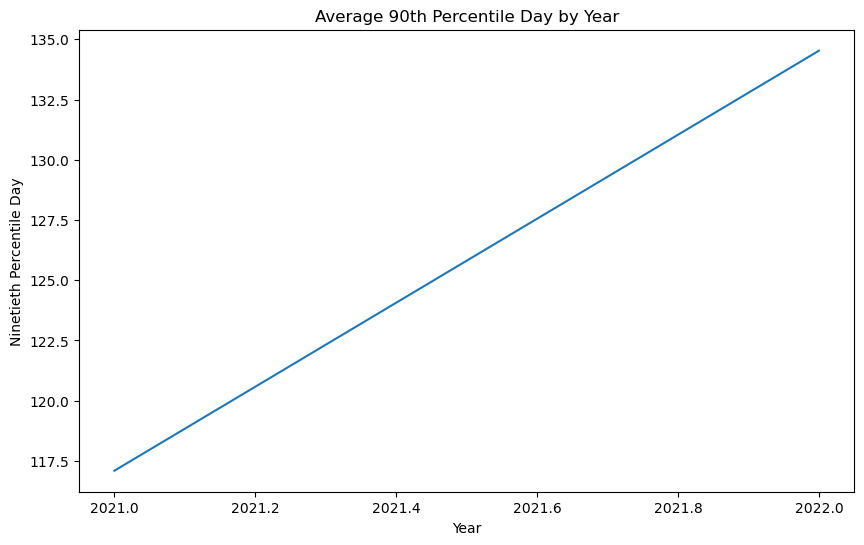

In [179]:
yearly_df = waiting_time_df.groupby("Year")["NinetiethPercentileDay"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="NinetiethPercentileDay", data=yearly_df)
plt.xlabel("Year")
plt.ylabel("Ninetieth Percentile Day")
plt.title("Average 90th Percentile Day by Year")
plt.show()

## EDA

<Axes: xlabel='IndicatorID'>

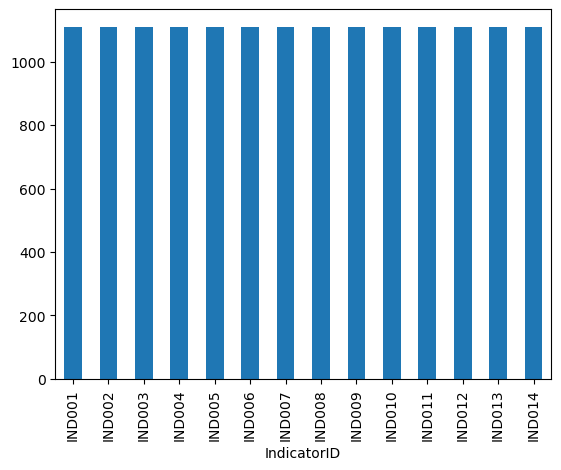

In [180]:
# Number of records in each category
waiting_time_df.groupby("IndicatorID")["IndicatorID"].count().plot(kind="bar")

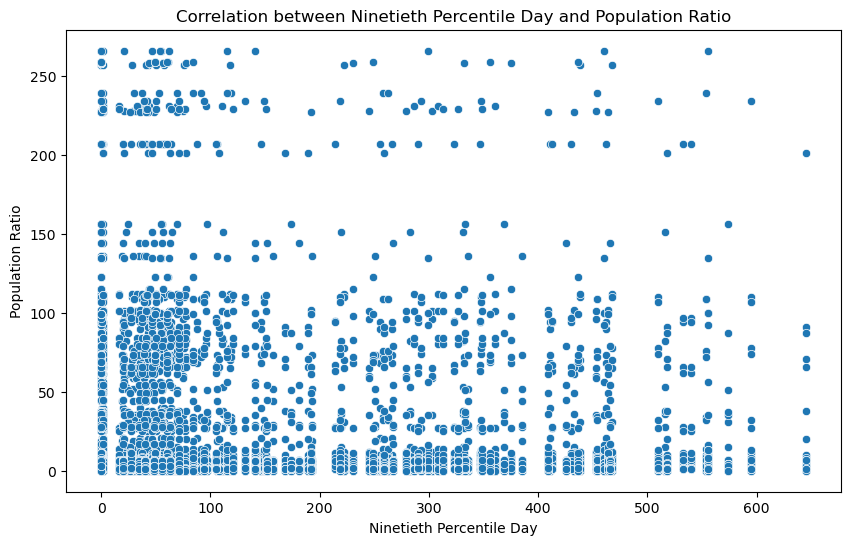

In [181]:
# Correlation between Ninetieth Percentile Day and Population Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x="NinetiethPercentileDay", y="PopulationRatio", data=waiting_time_df)
plt.xlabel("Ninetieth Percentile Day")
plt.ylabel("Population Ratio")
plt.title("Correlation between Ninetieth Percentile Day and Population Ratio")
plt.show()

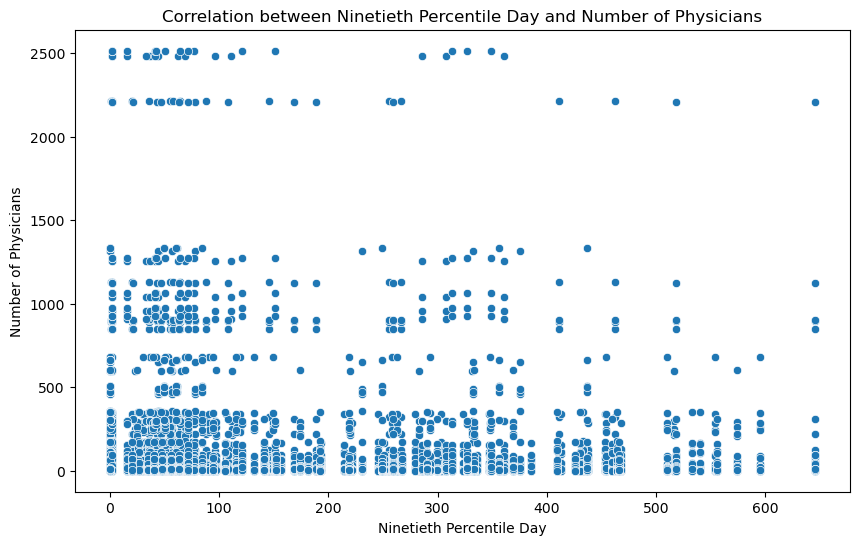

In [182]:
# Correlation between Ninetieth Percentile Day and Number of Physicians
plt.figure(figsize=(10, 6))
sns.scatterplot(x="NinetiethPercentileDay", y="NoOfPhysicians", data=waiting_time_df)
plt.xlabel("Ninetieth Percentile Day")
plt.ylabel("Number of Physicians")
plt.title("Correlation between Ninetieth Percentile Day and Number of Physicians")
plt.show()

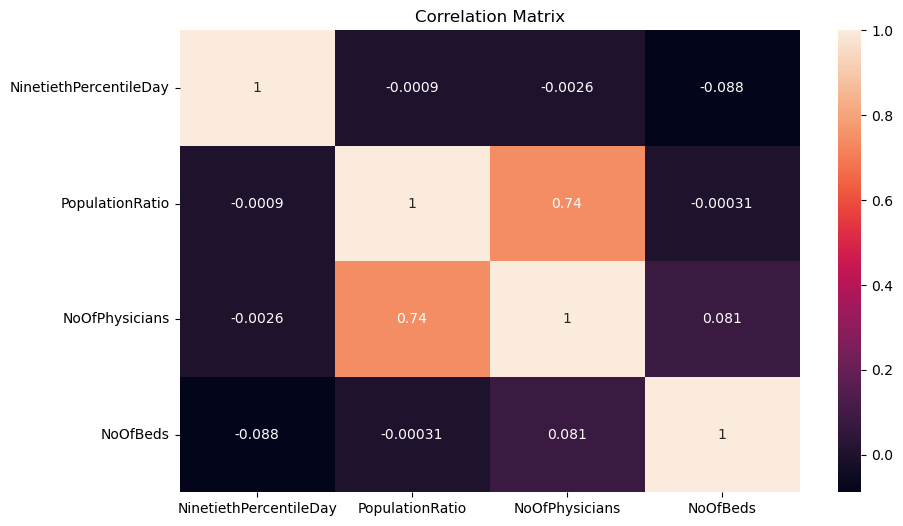

In [183]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(waiting_time_df[["NinetiethPercentileDay", "PopulationRatio", "NoOfPhysicians", "NoOfBeds"]].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

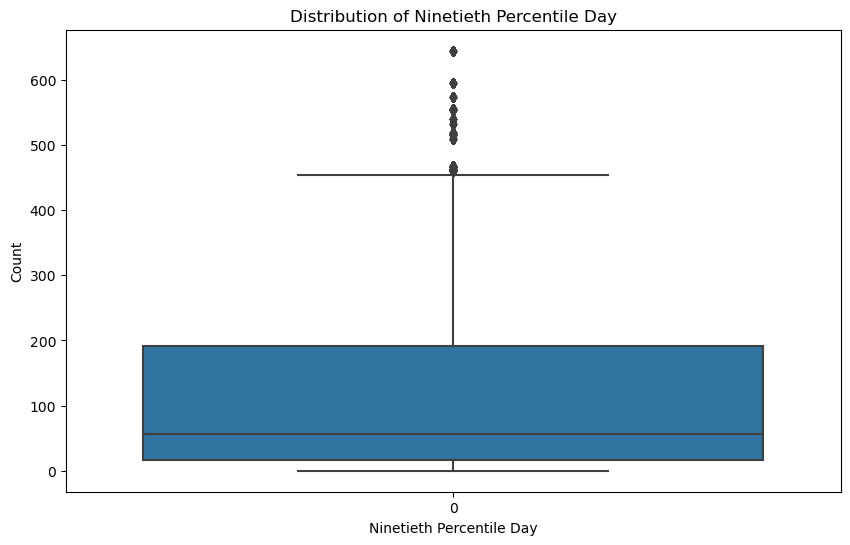

In [184]:
# graph the distribution of Ninetieth Percentile Day
plt.figure(figsize=(10, 6))
sns.boxplot(waiting_time_df["NinetiethPercentileDay"])
plt.xlabel("Ninetieth Percentile Day")
plt.ylabel("Count")
plt.title("Distribution of Ninetieth Percentile Day")
plt.show()

## Model Building

In [198]:
# import the necessary libraries for building different ml models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# import libraries for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# import libraries for train test split
from sklearn.model_selection import train_test_split

In [199]:
model_df = waiting_time_df.copy()

In [200]:
X = model_df.drop(["NinetiethPercentileDay"], axis=1)
y = model_df["NinetiethPercentileDay"]

In [201]:
one_hot_encoder = OneHotEncoder()

# Take out the categorical columns
X_cat = X[["ProvinceTerritoryID", "IndicatorID", "SpecialtyID"]]

# One hot encode the categorical columns
X_cat_encoded = one_hot_encoder.fit_transform(X_cat)

# Create a new dataframe with the encoded columns
X_encoded = pd.DataFrame(X_cat_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(X_cat.columns))

# Concatenate the original dataframe and the encoded dataframe
X_encoded = pd.concat([X.drop(["ProvinceTerritoryID", "IndicatorID", "SpecialtyID"], axis=1), X_encoded], axis=1)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [203]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print("Linear Regression:")
print("Mean Squared Error:", linear_mse)
print("Mean Absolute Error:", linear_mae)
print("R-squared:", linear_r2)

Linear Regression:
Mean Squared Error: 2900.529285383518
Mean Absolute Error: 37.24159474075032
R-squared: 0.8784699096345187


In [204]:
decision_tree = DecisionTreeRegressor(max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)
decision_tree_mse = mean_squared_error(y_test, y_pred_decision_tree)
decision_tree_mae = mean_absolute_error(y_test, y_pred_decision_tree)
decision_tree_r2 = r2_score(y_test, y_pred_decision_tree)

print("Decision Tree:")
print("Mean Squared Error:", decision_tree_mse)
print("Mean Absolute Error:", decision_tree_mae)
print("R-squared:", decision_tree_r2)

Decision Tree:
Mean Squared Error: 2191.5124682282158
Mean Absolute Error: 33.22114051260636
R-squared: 0.9081772041940827


In [205]:
random_forest = RandomForestRegressor(n_estimators=100, 
                                      max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)
random_forest_mse = mean_squared_error(y_test, y_pred_random_forest)
random_forest_mae = mean_absolute_error(y_test, y_pred_random_forest)
random_forest_r2 = r2_score(y_test, y_pred_random_forest)

print("Random Forest:")
print("Mean Squared Error:", random_forest_mse)
print("Mean Absolute Error:", random_forest_mae)
print("R-squared:", random_forest_r2)

Random Forest:
Mean Squared Error: 2173.3921437069253
Mean Absolute Error: 33.565511117469974
R-squared: 0.9089364327554427


In [206]:
neural_network = MLPRegressor(hidden_layer_sizes=(100, 50),
                              max_iter=1000,
                              random_state=42)
neural_network.fit(X_train, y_train)
y_pred_neural_network = neural_network.predict(X_test)
neural_network_mse = mean_squared_error(y_test, y_pred_neural_network)
neural_network_mae = mean_absolute_error(y_test, y_pred_neural_network)
neural_network_r2 = r2_score(y_test, y_pred_neural_network)

print("Neural Network:")
print("Mean Squared Error:", neural_network_mse)
print("Mean Absolute Error:", neural_network_mae)
print("R-squared:", neural_network_r2)

Neural Network:
Mean Squared Error: 3626.036935829373
Mean Absolute Error: 44.658011556471344
R-squared: 0.8480716610238778


In [207]:
# Dropping the number of physicians and population ratio
X_encoded = X_encoded.drop(["NoOfPhysicians", "PopulationRatio", "NoOfBeds"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [208]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print("Linear Regression:")
print("Mean Squared Error:", linear_mse)
print("Mean Absolute Error:", linear_mae)
print("R-squared:", linear_r2)

print("\n===================================================\n")

decision_tree = DecisionTreeRegressor(max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)
decision_tree_mse = mean_squared_error(y_test, y_pred_decision_tree)
decision_tree_mae = mean_absolute_error(y_test, y_pred_decision_tree)
decision_tree_r2 = r2_score(y_test, y_pred_decision_tree)

print("Decision Tree:")
print("Mean Squared Error:", decision_tree_mse)
print("Mean Absolute Error:", decision_tree_mae)
print("R-squared:", decision_tree_r2)

print("\n===================================================\n")

random_forest = RandomForestRegressor(n_estimators=100, 
                                      max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)
random_forest_mse = mean_squared_error(y_test, y_pred_random_forest)
random_forest_mae = mean_absolute_error(y_test, y_pred_random_forest)
random_forest_r2 = r2_score(y_test, y_pred_random_forest)

print("Random Forest:")
print("Mean Squared Error:", random_forest_mse)
print("Mean Absolute Error:", random_forest_mae)
print("R-squared:", random_forest_r2)

print("\n===================================================\n")

neural_network = MLPRegressor(hidden_layer_sizes=(100, 50),
                              max_iter=1000,
                              random_state=42)
neural_network.fit(X_train, y_train)
y_pred_neural_network = neural_network.predict(X_test)
neural_network_mse = mean_squared_error(y_test, y_pred_neural_network)
neural_network_mae = mean_absolute_error(y_test, y_pred_neural_network)
neural_network_r2 = r2_score(y_test, y_pred_neural_network)

print("Neural Network:")
print("Mean Squared Error:", neural_network_mse)
print("Mean Absolute Error:", neural_network_mae)
print("R-squared:", neural_network_r2)

print("\n===================================================\n")

Linear Regression:
Mean Squared Error: 2899.4181599122667
Mean Absolute Error: 37.19816484224082
R-squared: 0.8785164649924008


Decision Tree:
Mean Squared Error: 2379.843442875538
Mean Absolute Error: 35.24762433048522
R-squared: 0.9002862718449952


Random Forest:
Mean Squared Error: 2252.229615207675
Mean Absolute Error: 34.7721161162686
R-squared: 0.9056331994166331


Neural Network:
Mean Squared Error: 2718.8494576596295
Mean Absolute Error: 35.387315698211424
R-squared: 0.886082163712467




In [209]:
# Dropping columns with name starting from SpecialtyID
X_encoded = X_encoded.drop(X_encoded.filter(regex="SpecialtyID").columns, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [210]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print("Linear Regression:")
print("Mean Squared Error:", linear_mse)
print("Mean Absolute Error:", linear_mae)
print("R-squared:", linear_r2)

print("\n===================================================\n")

decision_tree = DecisionTreeRegressor(max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)
decision_tree_mse = mean_squared_error(y_test, y_pred_decision_tree)
decision_tree_mae = mean_absolute_error(y_test, y_pred_decision_tree)
decision_tree_r2 = r2_score(y_test, y_pred_decision_tree)

print("Decision Tree:")
print("Mean Squared Error:", decision_tree_mse)
print("Mean Absolute Error:", decision_tree_mae)
print("R-squared:", decision_tree_r2)

print("\n===================================================\n")

random_forest = RandomForestRegressor(n_estimators=100, 
                                      max_depth=5, 
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      random_state=42)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)
random_forest_mse = mean_squared_error(y_test, y_pred_random_forest)
random_forest_mae = mean_absolute_error(y_test, y_pred_random_forest)
random_forest_r2 = r2_score(y_test, y_pred_random_forest)

print("Random Forest:")
print("Mean Squared Error:", random_forest_mse)
print("Mean Absolute Error:", random_forest_mae)
print("R-squared:", random_forest_r2)

print("\n===================================================\n")

neural_network = MLPRegressor(hidden_layer_sizes=(100, 50),
                              max_iter=1000,
                              random_state=42)
neural_network.fit(X_train, y_train)
y_pred_neural_network = neural_network.predict(X_test)
neural_network_mse = mean_squared_error(y_test, y_pred_neural_network)
neural_network_mae = mean_absolute_error(y_test, y_pred_neural_network)
neural_network_r2 = r2_score(y_test, y_pred_neural_network)

print("Neural Network:")
print("Mean Squared Error:", neural_network_mse)
print("Mean Absolute Error:", neural_network_mae)
print("R-squared:", neural_network_r2)

print("\n===================================================\n")

Linear Regression:
Mean Squared Error: 2863.4772064150034
Mean Absolute Error: 36.86610592401803
R-squared: 0.8800223650873782


Decision Tree:
Mean Squared Error: 2379.843442875538
Mean Absolute Error: 35.24762433048522
R-squared: 0.9002862718449952


Random Forest:
Mean Squared Error: 2252.229615207675
Mean Absolute Error: 34.7721161162686
R-squared: 0.9056331994166331


Neural Network:
Mean Squared Error: 2933.9729663414637
Mean Absolute Error: 36.30330388154171
R-squared: 0.8770686434623566




## Model Evaluation on New Data

In [146]:
X_encoded.head()

,ProvinceTerritoryID_AB,ProvinceTerritoryID_MB,ProvinceTerritoryID_NB,ProvinceTerritoryID_NL,ProvinceTerritoryID_NS,ProvinceTerritoryID_ON,ProvinceTerritoryID_PE,ProvinceTerritoryID_QC,ProvinceTerritoryID_SK,Year_2008,...,IndicatorID_IND005,IndicatorID_IND006,IndicatorID_IND007,IndicatorID_IND008,IndicatorID_IND009,IndicatorID_IND010,IndicatorID_IND011,IndicatorID_IND012,IndicatorID_IND013,IndicatorID_IND014
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
